## Notes 
### Required installing Oracle JAVA 8 to get javabridge installed
### Then, I was able to install py-causal from https://bd2kccd.github.io/docs/py-causal/
### GFCI is slower than RFCI, but more accurate (SPIRTES), GFCI and RFCI account for unobserved variables, FGES assumes no unobserved variables.

Structure Learning Performance Guarantees If the assumptions in the previous section hold, then in the large sample limit, the CBN structure output by GFCId will contain an edge of one of four kinds between Xand Y   if and only if Xand Yare not independent conditional on any subset of the other measured variables of less than or equal to a specified size. In addition, there is (1) an arc X->Y   if and only if Xdirectly or indirectly causes Y, and Y   does not directly or indirectly cause X; (2) an edge X <-->Y   if and only if X   is not a direct or indirect cause of Yand Y   is not a direct or indirect cause of X(which can only occur if there are latent confounders of Xand some other variable or Yand some other variable; (3) an edge Xo->Y   only if Yis not a direct or indirect cause of X, but Xmay or may not be an indirect cause of Y; (4) an edge X o–o Y   indicates that Xand Y   are dependent no matter what subset of observed variables is conditioned on, but contains no orientation information (X   may be a direct or indirect cause of Y, and Ymay be an indirect cause of X, or there may be a latent common cause of Xand Y.

# Trying some various ML models

In [1]:
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle

# select your GPU Here
os.environ["CUDA_VISIBLE_DEVICES"]="1" #Comment this line out if you want all GPUS (2 hehe)

# python full-display web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def get_model(dense, dropouts, inputs):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))

    x = keras.layers.Dense(dense[0], activation = 'relu')(inputs)
    x = keras.layers.Dropout(dropouts[0])(x, training=True)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu')(x)
        x = keras.layers.Dropout(drop)(x, training=True)
    outputs = keras.layers.Dense(1, activation = 'linear')(x)
    model = keras.Model(inputs, outputs)
    return model


/home/tkyono/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s




def discrete_gauss(low, high, samples, std = 20):
    x = np.arange(low, high)
    xU, xL = x + 0.5, x - 0.5 
    prob = ss.norm.cdf(xU, scale = std) - ss.norm.cdf(xL, scale = std)
    prob = prob / prob.sum() #normalize the probabilities so their sum is 1
    nums = np.random.choice(x, size = samples, p = prob)
    return nums



def bar_plot(x_ax, val1, val1std, val2, val2std):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ## the data
    N = len(x_ax)

    ## necessary variables
    ind = np.arange(N)                # the x locations for the groups
    width = 0.35                      # the width of the bars
    fig.set_size_inches(18.5, 10.5)
    ## the bars
    rects1 = ax.bar(ind, val1, width,
                    color='gray',
                    yerr=val1std,
                    error_kw=dict(elinewidth=2,ecolor='blue'))

    rects2 = ax.bar(ind+width, val2, width,
                        color='blue',
                        #yerr=val2std,
                        error_kw=dict(elinewidth=2,ecolor='gray'))

    # axes and labels
    ax.set_xlim(-width,len(ind)+width)
    #ax.set_ylim(0,45)
    ax.set_ylabel('Percentage')
    ax.set_title('')
    plt.xticks(ind + width / 2, x_ax, rotation=75, size = 14)
    ## add a legend
    ax.legend( (rects1[0], rects2[0]), ('Accuracy', '% Violations') )
    fig.savefig("violations.pdf", bbox_inches='tight')
    plt.show()



def gen_data(mean = 0, var = 1, SIZE = 20000):
    a = np.random.normal(mean, var, SIZE)
    b = 1.1* a + np.random.normal(mean, var, SIZE)
    c =  0.5* b + np.random.normal(mean, var, SIZE)
    
    e = np.random.normal(mean, var, SIZE)
    
    d = e + b + np.random.normal(mean, var, SIZE)
    
    f= b +  d + np.random.normal(mean, var, SIZE)
    g = f + np.random.normal(mean,var, SIZE)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})


def get_CG(df, tetrad):
    tetrad.run(algoId = 'gfci', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
           structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
           completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)
    #tetrad.run(algoId = 'fges-mb', targetName = 'g', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
    #       structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
    #       completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)


    return tetrad.getTetradGraph()

def get_MB(graph, var, pc):
    parents = set()
    children = set()
    for i in pc.extractTetradGraphEdges(graph):
        if i[-1] == var and i[3:5] == '->':
            parents.add(i[0])
        if i[0] == var and i[3:5] == '->':
            children.add(i[-1])
    return parents, children

from pycausal.pycausal import pycausal as pc
from collections import defaultdict
pc = pc()
pc.start_vm(java_max_heap_size = '5000M')
tetrad = s.tetradrunner()


verbosity = 1



models = []
model_names = []

num_models = 100

randomize = True
if randomize:
    layers = [256, 512, 1024, 2048, 4096]
    for i in range(num_models):
        network = []
        for j in range(3):
            network.append(layers[random.randint(0,len(layers) -1)])
        models.append(network)
        model_names.append('temp/rand' + str(i))
    print(models, model_names)    
else:
    model_layers = [512,256]
    for i in range(num_models):
        models.append(model_layers)
        model_names.append('temp/f' + str(i))


print(models, model_names)

inputs = ['a', 'b', 'c', 'd', 'e', 'f']
target = ['g']
df = gen_data()
X = df[inputs].values
y = df[target].values

val_df = gen_data(SIZE = 2000)
x_val = df[inputs].values
y_val = df[target].values



/home/tkyono/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


[[2048, 256, 1024], [2048, 512, 512], [256, 1024, 1024], [256, 4096, 256], [4096, 1024, 1024], [1024, 1024, 2048], [2048, 512, 1024], [4096, 1024, 512], [256, 512, 2048], [512, 1024, 256], [2048, 4096, 2048], [2048, 1024, 4096], [4096, 1024, 1024], [1024, 4096, 256], [256, 512, 1024], [256, 2048, 512], [2048, 2048, 1024], [256, 2048, 2048], [256, 4096, 2048], [1024, 256, 2048], [256, 512, 1024], [4096, 512, 256], [256, 4096, 4096], [256, 4096, 2048], [256, 4096, 1024], [4096, 2048, 256], [2048, 4096, 512], [2048, 2048, 2048], [2048, 256, 512], [256, 2048, 256], [256, 4096, 1024], [256, 1024, 2048], [2048, 2048, 1024], [4096, 512, 256], [4096, 512, 1024], [256, 4096, 1024], [4096, 4096, 512], [1024, 1024, 4096], [512, 1024, 4096], [2048, 4096, 256], [256, 256, 2048], [2048, 512, 512], [2048, 1024, 2048], [2048, 1024, 256], [1024, 2048, 2048], [2048, 512, 512], [256, 256, 4096], [2048, 512, 1024], [2048, 512, 4096], [256, 512, 4096], [2048, 1024, 512], [2048, 4096, 2048], [512, 1024, 204

In [3]:
for idx, model_name in enumerate(model_names):
    print(model_name)

    if type(models[idx]) is list:
        #clear session
        keras.backend.clear_session() 
        #get model according to specification
        model = get_model(models[idx], [0.2] * len(models), len(inputs))
        callbacks = [ModelCheckpoint(model_name, verbose= verbosity, monitor='val_loss',save_best_only=True), 
                     EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose= verbosity, mode='auto')]
        model.compile(optimizer = optimizers.SGD(lr = 0.001, momentum = 0.9, ), loss='mean_squared_error', metrics = ['mse'])
        #print(len(X), len(y))
        model.fit(X, y, epochs = 20, validation_data = (x_val, y_val), callbacks = callbacks, batch_size = 32, verbose = verbosity)
    else:
        models[idx].fit(X,y)


temp/rand0
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 153us/step - loss: 1.3846 - mean_squared_error: 1.3846 - val_loss: 1.1054 - val_mean_squared_error: 1.1054

Epoch 00001: val_loss improved from inf to 1.10540, saving model to temp/rand0
Epoch 2/20
20000/20000 [==============================] - 2s 110us/step - loss: 1.1056 - mean_squared_error: 1.1056 - val_loss: 1.0856 - val_mean_squared_error: 1.0856

Epoch 00002: val_loss improved from 1.10540 to 1.08555, saving model to temp/rand0
Epoch 3/20
20000/20000 [==============================] - 2s 111us/step - loss: 1.0872 - mean_squared_error: 1.0872 - val_loss: 1.0779 - val_mean_squared_error: 1.0779

Epoch 00003: val_loss improved from 1.08555 to 1.07785, saving model to temp/rand0
Epoch 4/20
20000/20000 [==============================] - 2s 113us/step - loss: 1.0654 - mean_squared_error: 1.0654 - val_loss: 1.0667 - val_mean_squared_error: 1.0667

Epoch 00004: val_l


Epoch 00008: val_loss improved from 1.02723 to 1.02565, saving model to temp/rand4
Epoch 9/20
20000/20000 [==============================] - 3s 132us/step - loss: 1.0438 - mean_squared_error: 1.0438 - val_loss: 1.0184 - val_mean_squared_error: 1.0184

Epoch 00009: val_loss improved from 1.02565 to 1.01839, saving model to temp/rand4
Epoch 10/20
20000/20000 [==============================] - 3s 134us/step - loss: 1.0416 - mean_squared_error: 1.0416 - val_loss: 1.0221 - val_mean_squared_error: 1.0221

Epoch 00010: val_loss did not improve from 1.01839
Epoch 11/20
20000/20000 [==============================] - 3s 134us/step - loss: 1.0417 - mean_squared_error: 1.0417 - val_loss: 1.0346 - val_mean_squared_error: 1.0346

Epoch 00011: val_loss did not improve from 1.01839
Epoch 00011: early stopping
temp/rand5
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 139us/step - loss: 1.2794 - mean_squared_error: 1.2794 - val_loss: 1.053

Epoch 4/20
20000/20000 [==============================] - 4s 203us/step - loss: 1.0393 - mean_squared_error: 1.0393 - val_loss: 1.0297 - val_mean_squared_error: 1.0297

Epoch 00004: val_loss did not improve from 1.01970
Epoch 5/20
20000/20000 [==============================] - 4s 203us/step - loss: 1.0411 - mean_squared_error: 1.0411 - val_loss: 1.0565 - val_mean_squared_error: 1.0565

Epoch 00005: val_loss did not improve from 1.01970
Epoch 00005: early stopping
temp/rand11
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 161us/step - loss: 1.2890 - mean_squared_error: 1.2890 - val_loss: 1.0630 - val_mean_squared_error: 1.0630

Epoch 00001: val_loss improved from inf to 1.06304, saving model to temp/rand11
Epoch 2/20
20000/20000 [==============================] - 3s 145us/step - loss: 1.0531 - mean_squared_error: 1.0531 - val_loss: 1.0275 - val_mean_squared_error: 1.0275

Epoch 00002: val_loss improved from 1.06304 to 1.027


Epoch 00010: val_loss did not improve from 1.04611
Epoch 00010: early stopping
temp/rand16
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 157us/step - loss: 1.2147 - mean_squared_error: 1.2147 - val_loss: 1.0514 - val_mean_squared_error: 1.0514

Epoch 00001: val_loss improved from inf to 1.05142, saving model to temp/rand16
Epoch 2/20
20000/20000 [==============================] - 3s 143us/step - loss: 1.0584 - mean_squared_error: 1.0584 - val_loss: 1.0326 - val_mean_squared_error: 1.0326

Epoch 00002: val_loss improved from 1.05142 to 1.03263, saving model to temp/rand16
Epoch 3/20
20000/20000 [==============================] - 3s 146us/step - loss: 1.0540 - mean_squared_error: 1.0540 - val_loss: 1.0334 - val_mean_squared_error: 1.0334

Epoch 00003: val_loss did not improve from 1.03263
Epoch 4/20
20000/20000 [==============================] - 3s 143us/step - loss: 1.0554 - mean_squared_error: 1.0554 - val_loss: 1.0354 -

20000/20000 [==============================] - 3s 127us/step - loss: 1.0755 - mean_squared_error: 1.0755 - val_loss: 1.0632 - val_mean_squared_error: 1.0632

Epoch 00007: val_loss did not improve from 1.05460
Epoch 00007: early stopping
temp/rand22
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 5s 239us/step - loss: 1.2545 - mean_squared_error: 1.2545 - val_loss: 1.0608 - val_mean_squared_error: 1.0608

Epoch 00001: val_loss improved from inf to 1.06081, saving model to temp/rand22
Epoch 2/20
20000/20000 [==============================] - 4s 207us/step - loss: 1.0779 - mean_squared_error: 1.0779 - val_loss: 1.0551 - val_mean_squared_error: 1.0551

Epoch 00002: val_loss improved from 1.06081 to 1.05514, saving model to temp/rand22
Epoch 3/20
20000/20000 [==============================] - 4s 206us/step - loss: 1.0653 - mean_squared_error: 1.0653 - val_loss: 1.0426 - val_mean_squared_error: 1.0426

Epoch 00003: val_loss improved

20000/20000 [==============================] - 3s 162us/step - loss: 1.2505 - mean_squared_error: 1.2505 - val_loss: 1.0389 - val_mean_squared_error: 1.0389

Epoch 00001: val_loss improved from inf to 1.03894, saving model to temp/rand27
Epoch 2/20
20000/20000 [==============================] - 3s 148us/step - loss: 1.0620 - mean_squared_error: 1.0620 - val_loss: 1.0415 - val_mean_squared_error: 1.0415

Epoch 00002: val_loss did not improve from 1.03894
Epoch 3/20
20000/20000 [==============================] - 3s 150us/step - loss: 1.0543 - mean_squared_error: 1.0543 - val_loss: 1.0544 - val_mean_squared_error: 1.0544

Epoch 00003: val_loss did not improve from 1.03894
Epoch 00003: early stopping
temp/rand28
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 123us/step - loss: 1.3810 - mean_squared_error: 1.3810 - val_loss: 1.1134 - val_mean_squared_error: 1.1134

Epoch 00001: val_loss improved from inf to 1.11343, saving mode

20000/20000 [==============================] - 3s 152us/step - loss: 1.2184 - mean_squared_error: 1.2184 - val_loss: 1.0973 - val_mean_squared_error: 1.0973

Epoch 00001: val_loss improved from inf to 1.09732, saving model to temp/rand32
Epoch 2/20
20000/20000 [==============================] - 3s 137us/step - loss: 1.0575 - mean_squared_error: 1.0575 - val_loss: 1.0415 - val_mean_squared_error: 1.0415

Epoch 00002: val_loss improved from 1.09732 to 1.04154, saving model to temp/rand32
Epoch 3/20
20000/20000 [==============================] - 3s 135us/step - loss: 1.0557 - mean_squared_error: 1.0557 - val_loss: 1.0504 - val_mean_squared_error: 1.0504

Epoch 00003: val_loss did not improve from 1.04154
Epoch 4/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0590 - mean_squared_error: 1.0590 - val_loss: 1.0342 - val_mean_squared_error: 1.0342

Epoch 00004: val_loss improved from 1.04154 to 1.03422, saving model to temp/rand32
Epoch 5/20
20000/20000 [============


Epoch 00003: val_loss did not improve from 1.03799
Epoch 4/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0555 - mean_squared_error: 1.0555 - val_loss: 1.0357 - val_mean_squared_error: 1.0357

Epoch 00004: val_loss improved from 1.03799 to 1.03566, saving model to temp/rand37
Epoch 5/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0467 - mean_squared_error: 1.0467 - val_loss: 1.0410 - val_mean_squared_error: 1.0410

Epoch 00005: val_loss did not improve from 1.03566
Epoch 6/20
20000/20000 [==============================] - 3s 132us/step - loss: 1.0497 - mean_squared_error: 1.0497 - val_loss: 1.0856 - val_mean_squared_error: 1.0856

Epoch 00006: val_loss did not improve from 1.03566
Epoch 00006: early stopping
temp/rand38
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 141us/step - loss: 1.2873 - mean_squared_error: 1.2873 - val_loss: 1.0724 - val_mean_squared_error: 1.07

20000/20000 [==============================] - 2s 116us/step - loss: 1.0814 - mean_squared_error: 1.0814 - val_loss: 1.0791 - val_mean_squared_error: 1.0791

Epoch 00006: val_loss did not improve from 1.07881
Epoch 00006: early stopping
temp/rand44
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 152us/step - loss: 1.2404 - mean_squared_error: 1.2404 - val_loss: 1.0703 - val_mean_squared_error: 1.0703

Epoch 00001: val_loss improved from inf to 1.07028, saving model to temp/rand44
Epoch 2/20
20000/20000 [==============================] - 3s 136us/step - loss: 1.0571 - mean_squared_error: 1.0571 - val_loss: 1.0360 - val_mean_squared_error: 1.0360

Epoch 00002: val_loss improved from 1.07028 to 1.03596, saving model to temp/rand44
Epoch 3/20
20000/20000 [==============================] - 3s 136us/step - loss: 1.0570 - mean_squared_error: 1.0570 - val_loss: 1.0260 - val_mean_squared_error: 1.0260

Epoch 00003: val_loss improved

20000/20000 [==============================] - 2s 117us/step - loss: 1.0917 - mean_squared_error: 1.0917 - val_loss: 1.0904 - val_mean_squared_error: 1.0904

Epoch 00003: val_loss improved from 1.12847 to 1.09036, saving model to temp/rand49
Epoch 4/20
20000/20000 [==============================] - 2s 116us/step - loss: 1.0832 - mean_squared_error: 1.0832 - val_loss: 1.0564 - val_mean_squared_error: 1.0564

Epoch 00004: val_loss improved from 1.09036 to 1.05645, saving model to temp/rand49
Epoch 5/20
20000/20000 [==============================] - 2s 117us/step - loss: 1.0768 - mean_squared_error: 1.0768 - val_loss: 1.0694 - val_mean_squared_error: 1.0694

Epoch 00005: val_loss did not improve from 1.05645
Epoch 6/20
20000/20000 [==============================] - 2s 117us/step - loss: 1.0635 - mean_squared_error: 1.0635 - val_loss: 1.0617 - val_mean_squared_error: 1.0617

Epoch 00006: val_loss did not improve from 1.05645
Epoch 00006: early stopping
temp/rand50
Train on 20000 samples, v

20000/20000 [==============================] - 3s 144us/step - loss: 1.2551 - mean_squared_error: 1.2551 - val_loss: 1.0547 - val_mean_squared_error: 1.0547

Epoch 00001: val_loss improved from inf to 1.05474, saving model to temp/rand56
Epoch 2/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0703 - mean_squared_error: 1.0703 - val_loss: 1.0641 - val_mean_squared_error: 1.0641

Epoch 00002: val_loss did not improve from 1.05474
Epoch 3/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0724 - mean_squared_error: 1.0724 - val_loss: 1.0742 - val_mean_squared_error: 1.0742

Epoch 00003: val_loss did not improve from 1.05474
Epoch 00003: early stopping
temp/rand57
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 144us/step - loss: 1.2942 - mean_squared_error: 1.2942 - val_loss: 1.0585 - val_mean_squared_error: 1.0585

Epoch 00001: val_loss improved from inf to 1.05850, saving mode

20000/20000 [==============================] - 2s 115us/step - loss: 1.0599 - mean_squared_error: 1.0599 - val_loss: 1.0631 - val_mean_squared_error: 1.0631

Epoch 00012: val_loss did not improve from 1.05133
Epoch 00012: early stopping
temp/rand61
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 165us/step - loss: 1.2047 - mean_squared_error: 1.2047 - val_loss: 1.0423 - val_mean_squared_error: 1.0423

Epoch 00001: val_loss improved from inf to 1.04233, saving model to temp/rand61
Epoch 2/20
20000/20000 [==============================] - 3s 148us/step - loss: 1.0547 - mean_squared_error: 1.0547 - val_loss: 1.0503 - val_mean_squared_error: 1.0503

Epoch 00002: val_loss did not improve from 1.04233
Epoch 3/20
20000/20000 [==============================] - 3s 150us/step - loss: 1.0564 - mean_squared_error: 1.0564 - val_loss: 1.0653 - val_mean_squared_error: 1.0653

Epoch 00003: val_loss did not improve from 1.04233
Epoch 00003:

20000/20000 [==============================] - 2s 117us/step - loss: 1.0682 - mean_squared_error: 1.0682 - val_loss: 1.0666 - val_mean_squared_error: 1.0666

Epoch 00005: val_loss did not improve from 1.04524
Epoch 6/20
20000/20000 [==============================] - 2s 122us/step - loss: 1.0771 - mean_squared_error: 1.0771 - val_loss: 1.0584 - val_mean_squared_error: 1.0584

Epoch 00006: val_loss did not improve from 1.04524
Epoch 00006: early stopping
temp/rand67
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.2632 - mean_squared_error: 1.2632 - val_loss: 1.0902 - val_mean_squared_error: 1.0902

Epoch 00001: val_loss improved from inf to 1.09019, saving model to temp/rand67
Epoch 2/20
20000/20000 [==============================] - 2s 118us/step - loss: 1.0860 - mean_squared_error: 1.0860 - val_loss: 1.0723 - val_mean_squared_error: 1.0723

Epoch 00002: val_loss improved from 1.09019 to 1.07233, saving 

20000/20000 [==============================] - 3s 125us/step - loss: 1.0599 - mean_squared_error: 1.0599 - val_loss: 1.0462 - val_mean_squared_error: 1.0462

Epoch 00002: val_loss improved from 1.07818 to 1.04618, saving model to temp/rand73
Epoch 3/20
20000/20000 [==============================] - 3s 125us/step - loss: 1.0527 - mean_squared_error: 1.0527 - val_loss: 1.0284 - val_mean_squared_error: 1.0284

Epoch 00003: val_loss improved from 1.04618 to 1.02837, saving model to temp/rand73
Epoch 4/20
20000/20000 [==============================] - 2s 124us/step - loss: 1.0574 - mean_squared_error: 1.0574 - val_loss: 1.0334 - val_mean_squared_error: 1.0334

Epoch 00004: val_loss did not improve from 1.02837
Epoch 5/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0468 - mean_squared_error: 1.0468 - val_loss: 1.0383 - val_mean_squared_error: 1.0383

Epoch 00005: val_loss did not improve from 1.02837
Epoch 00005: early stopping
temp/rand74
Train on 20000 samples, v

20000/20000 [==============================] - 2s 120us/step - loss: 1.0717 - mean_squared_error: 1.0717 - val_loss: 1.0409 - val_mean_squared_error: 1.0409

Epoch 00002: val_loss improved from 1.07433 to 1.04094, saving model to temp/rand79
Epoch 3/20
20000/20000 [==============================] - 2s 120us/step - loss: 1.0718 - mean_squared_error: 1.0718 - val_loss: 1.0408 - val_mean_squared_error: 1.0408

Epoch 00003: val_loss improved from 1.04094 to 1.04082, saving model to temp/rand79
Epoch 4/20
20000/20000 [==============================] - 2s 119us/step - loss: 1.0591 - mean_squared_error: 1.0591 - val_loss: 1.0452 - val_mean_squared_error: 1.0452

Epoch 00004: val_loss did not improve from 1.04082
Epoch 5/20
20000/20000 [==============================] - 2s 119us/step - loss: 1.0615 - mean_squared_error: 1.0615 - val_loss: 1.0626 - val_mean_squared_error: 1.0626

Epoch 00005: val_loss did not improve from 1.04082
Epoch 00005: early stopping
temp/rand80
Train on 20000 samples, v

20000/20000 [==============================] - 2s 114us/step - loss: 1.0526 - mean_squared_error: 1.0526 - val_loss: 1.0802 - val_mean_squared_error: 1.0802

Epoch 00010: val_loss did not improve from 1.03577
Epoch 11/20
20000/20000 [==============================] - 2s 110us/step - loss: 1.0586 - mean_squared_error: 1.0586 - val_loss: 1.0943 - val_mean_squared_error: 1.0943

Epoch 00011: val_loss did not improve from 1.03577
Epoch 00011: early stopping
temp/rand84
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 123us/step - loss: 1.3263 - mean_squared_error: 1.3263 - val_loss: 1.1362 - val_mean_squared_error: 1.1362

Epoch 00001: val_loss improved from inf to 1.13616, saving model to temp/rand84
Epoch 2/20
20000/20000 [==============================] - 2s 111us/step - loss: 1.1240 - mean_squared_error: 1.1240 - val_loss: 1.0891 - val_mean_squared_error: 1.0891

Epoch 00002: val_loss improved from 1.13616 to 1.08908, saving


Epoch 00001: val_loss improved from inf to 1.17416, saving model to temp/rand88
Epoch 2/20
20000/20000 [==============================] - 2s 112us/step - loss: 1.1392 - mean_squared_error: 1.1392 - val_loss: 1.1580 - val_mean_squared_error: 1.1580

Epoch 00002: val_loss improved from 1.17416 to 1.15801, saving model to temp/rand88
Epoch 3/20
20000/20000 [==============================] - 2s 114us/step - loss: 1.1176 - mean_squared_error: 1.1176 - val_loss: 1.0962 - val_mean_squared_error: 1.0962

Epoch 00003: val_loss improved from 1.15801 to 1.09617, saving model to temp/rand88
Epoch 4/20
20000/20000 [==============================] - 2s 112us/step - loss: 1.1039 - mean_squared_error: 1.1039 - val_loss: 1.0781 - val_mean_squared_error: 1.0781

Epoch 00004: val_loss improved from 1.09617 to 1.07807, saving model to temp/rand88
Epoch 5/20
20000/20000 [==============================] - 2s 113us/step - loss: 1.0995 - mean_squared_error: 1.0995 - val_loss: 1.1142 - val_mean_squared_error:

20000/20000 [==============================] - 2s 114us/step - loss: 1.0882 - mean_squared_error: 1.0882 - val_loss: 1.2086 - val_mean_squared_error: 1.2086

Epoch 00002: val_loss did not improve from 1.07769
Epoch 3/20
20000/20000 [==============================] - 2s 115us/step - loss: 1.0963 - mean_squared_error: 1.0963 - val_loss: 1.1081 - val_mean_squared_error: 1.1081

Epoch 00003: val_loss did not improve from 1.07769
Epoch 00003: early stopping
temp/rand94
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 5s 237us/step - loss: 1.2561 - mean_squared_error: 1.2561 - val_loss: 1.0242 - val_mean_squared_error: 1.0242

Epoch 00001: val_loss improved from inf to 1.02417, saving model to temp/rand94
Epoch 2/20
20000/20000 [==============================] - 4s 197us/step - loss: 1.0451 - mean_squared_error: 1.0451 - val_loss: 1.0401 - val_mean_squared_error: 1.0401

Epoch 00002: val_loss did not improve from 1.02417
Epoch 3/20
2


Epoch 00002: val_loss did not improve from 1.05379
Epoch 3/20
20000/20000 [==============================] - 3s 137us/step - loss: 1.0641 - mean_squared_error: 1.0641 - val_loss: 1.0416 - val_mean_squared_error: 1.0416

Epoch 00003: val_loss improved from 1.05379 to 1.04157, saving model to temp/rand99
Epoch 4/20
20000/20000 [==============================] - 3s 135us/step - loss: 1.0592 - mean_squared_error: 1.0592 - val_loss: 1.0443 - val_mean_squared_error: 1.0443

Epoch 00004: val_loss did not improve from 1.04157
Epoch 5/20
20000/20000 [==============================] - 3s 139us/step - loss: 1.0600 - mean_squared_error: 1.0600 - val_loss: 1.0980 - val_mean_squared_error: 1.0980

Epoch 00005: val_loss did not improve from 1.04157
Epoch 00005: early stopping


In [4]:
nb_test = 2000
metrics_dicts = []
shap_dicts = []
shap_var = []
for m in models:
    metrics_dicts.append(defaultdict(list))
    shap_dicts.append(defaultdict(list))
    shap_var.append(defaultdict(list))
#means = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#variances = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
#means = [0, 0.5, 1.0, 1.5, 2]
#variances = [1, 1.5, 2, 2.5, 3, 3.5]
means = [0, 1,2]
variances = [1, 2,3]


import shap
shap.initjs()
def get_shap(model, df, samples):
    x_train = df[inputs][:(samples * 2)]
    explainer_shap = shap.DeepExplainer(model=model, data=x_train)
    shap_values = explainer_shap.shap_values(X=x_train.values[:samples],ranked_outputs = True)
    #shap.summary_plot(shap_values[0], x_train.values[:samples], feature_names = x_train.columns)
    l = []
    for f, feat in enumerate(inputs):
        tot = 0
        for i in shap_values[0]:
            for j in i:
                tot += np.abs(j[f])
        l.append(tot/samples)
    return l

nshap = 500
base_df = gen_data()
def norm(a):
    return a / np.sum(a)
base_shap = norm(get_shap(model, df, nshap))
#shap_var.append(base_shap)


from sklearn.metrics import mean_absolute_error
# ok at this point we need to check the model on various variances and means
for m in means:
    for v in variances:
        print("<<<<<<<<", m,v)
        #t0 = time.time()
        perturbed_df = gen_data(mean =m, var = v, SIZE = nb_test)
        y_test2 = perturbed_df[target]
        x_test2 = perturbed_df[inputs]
        #t1 = time.time()
        #print("Time for gen_data = ", t1 - t0)
        for idx, model_name in enumerate(model_names):
            print(model_name)
            #t0 = time.time()
            if type(models[idx]) is list:
                keras.backend.clear_session()
                model = load_model(model_name)
            else:
                model = models[idx]
            #t1 = time.time()
            #print("Time to load model = ", t1 - t0)
            
            y_pred2 = model.predict(x_test2)
            metrics_dicts[idx][str(m) + '_' + str(v)].append(mean_squared_error(y_test2, y_pred2))
            pred_shap = get_shap(model, x_test2, nshap)
            shap_dicts[idx][str(m) + '_' + str(v)].append(mean_absolute_error(base_shap, pred_shap))
            shap_var[idx][str(m) + '_' + str(v)].append(pred_shap)
            print(mean_absolute_error(base_shap, pred_shap))
            print(pred_shap)


<<<<<<<< 0 1
temp/rand0
0.323519272405228
[0.01495111686271451, 0.0374057901705168, 0.02239412215865712, 0.024281626096329733, 0.00971493920614308, 2.832368039937007]
temp/rand1
0.3277490983321423
[0.017431109398678982, 0.010108034890483468, 0.012607817194211432, 0.025062824615829198, 0.008991478486577706, 2.892293325407073]
temp/rand2
0.32544695435445187
[0.01911376672326831, 0.01961657962071988, 0.022994921224048955, 0.048779720936362576, 0.01292741192039191, 2.8292493257019196]
temp/rand3
0.3147070977132565
[0.013842496351736752, 0.015276676931021705, 0.013928925801417056, 0.031106936326144047, 0.023155148636323515, 2.790932402232896]
temp/rand4
0.32343974882248366
[0.013835442249700618, 0.02590930734796776, 0.012851398738861675, 0.02890018078886815, 0.008396719802407419, 2.8507454440070963]
temp/rand5
0.33533266058572186
[0.0145907148618377, 0.025668096951786654, 0.011409583891659131, 0.021720209389081764, 0.012069517076809843, 2.926537841343156]
temp/rand6
0.32852119825297604
[0.0

0.3331483757455413
[0.014189657206475706, 0.04032588327902818, 0.01240426422298251, 0.05072271671323229, 0.007920236083803586, 2.8733274969677254]
temp/rand53
0.3178366643879503
[0.015482932467867364, 0.015490281730198353, 0.0157935771596813, 0.04944054210173392, 0.011712395876050757, 2.79910025699217]
temp/rand54
0.3151268801692043
[0.01354572706662215, 0.03460621182480381, 0.01814600129266312, 0.02906934755417964, 0.011842093017367088, 2.78355190025959]
temp/rand55
0.323277941807307
[0.01022214514416937, 0.024734948343470755, 0.01869458310758641, 0.048256146490551405, 0.01163822866192631, 2.8261215990961377]
temp/rand56
0.3275629595552463
[0.01596147020106099, 0.02554549296650496, 0.013224493554437574, 0.10182933095395533, 0.005829735263320839, 2.802987234392198]
temp/rand57
0.3309534396736052
[0.008593945244937375, 0.03687665625933071, 0.009408052874599624, 0.05054170246593328, 0.017121680405463975, 2.863178600791366]
temp/rand58
0.32830492039042536
[0.00929453351071523, 0.023797773

0.7910180200918676
[0.03077669967866653, 0.061234436719503765, 0.02543919166443279, 0.05229915035345488, 0.019061393356240124, 5.557297248778908]
temp/rand5
0.8108672109755862
[0.03177355078582857, 0.06075573455667191, 0.02295883267674808, 0.04141809142194728, 0.02903090879974418, 5.679266147612577]
temp/rand6
0.7965117130233176
[0.029273522995693482, 0.10001407617379791, 0.02877572355617346, 0.07684343859331104, 0.01571542266304807, 5.528448094157882]
temp/rand7
0.807435194478551
[0.042743138075990623, 0.058405048597541045, 0.0231135428841488, 0.09758252203026209, 0.03452988484433574, 5.5882370304390285]
temp/rand8
0.7665392188319412
[0.032494440797761814, 0.12547704226074763, 0.038577539073523195, 0.06547803370998716, 0.04523921728248105, 5.291969039867147]
temp/rand9
0.7855567889753408
[0.03571921262431787, 0.09246299537398846, 0.020566091364874483, 0.14078619146970303, 0.03438720615413694, 5.389419036865024]
temp/rand10
0.8023830905350998
[0.04521367235457761, 0.060720372091153434,

0.8041085235153829
[0.016513746239088706, 0.07965281778250115, 0.018474924904876813, 0.12013820484081089, 0.03775022551802045, 5.552121221807]
temp/rand58
0.7980925699382456
[0.017254820428508635, 0.04982836901315597, 0.03474995612179383, 0.05538498503655094, 0.020536227713093325, 5.610801061316372]
temp/rand59
0.7770672530082625
[0.023851761389398905, 0.10154530224230099, 0.025349383702230468, 0.18140361517318998, 0.0122008316126128, 5.318052623929843]
temp/rand60
0.7416585672629626
[0.02535713295330707, 0.08813959883769432, 0.030420374848826273, 0.06420609289323184, 0.02041077348848194, 5.221417430556235]
temp/rand61
0.8295003351768866
[0.01883265647930311, 0.15256256143055072, 0.03642399752842127, 0.05671520133157352, 0.030854734005434294, 5.681612860286037]
temp/rand62
0.7755812228505711
[0.011148567979996396, 0.09050168119022438, 0.01703718490831654, 0.2047006422405679, 0.015854514254136857, 5.314244746530185]
temp/rand63
0.7854096849376532
[0.021368390893295328, 0.092303128652179

1.2853630005798191
[0.06281692541240513, 0.09419375885371006, 0.044081697214436937, 0.17414589538075886, 0.06936024008213153, 8.267579486535473]
temp/rand11
1.3110713930414215
[0.07332908903929265, 0.21892434714022202, 0.0540813371716538, 0.0734632603585522, 0.056306997500412626, 8.390323327038397]
temp/rand12
1.2969384377764073
[0.06724921678803268, 0.09485075532083072, 0.06296410831978773, 0.17275614243319068, 0.026282036122570178, 8.357528367674032]
temp/rand13
1.2789678373225966
[0.028743009054550607, 0.09364625415560862, 0.05433299303375271, 0.07669428031464495, 0.02253416456039579, 8.397856322816628]
temp/rand14
1.2349821464798536
[0.02501445790794933, 0.19529378954311177, 0.1115079351256792, 0.1602820408079178, 0.03243830600542293, 7.885356349489041]
temp/rand15
1.2639020829267638
[0.024791677660073643, 0.15550676234292637, 0.0769756325414208, 0.0597354009242259, 0.03190501164234519, 8.23449801244959]
temp/rand16
1.2673770021751702
[0.03726323614084977, 0.04793214370912693, 0.02

1.2523899123336317
[0.02973233956743249, 0.14282621686640257, 0.028120831817768515, 0.16305748147037696, 0.03275693124269529, 8.117845673037115]
temp/rand64
1.2749397633012338
[0.06942883797036023, 0.07949184808646423, 0.04000528537752553, 0.11445021007137812, 0.02943242023843264, 8.316829978063243]
temp/rand65
1.2624403008938103
[0.03997980462951873, 0.11006567171950929, 0.030123996807259305, 0.08177433679150097, 0.043600099433799964, 8.269097895981274]
temp/rand66
1.256746593323493
[0.02793537519498104, 0.06542029366939654, 0.024192113069880998, 0.08984361379320345, 0.0277421935911846, 8.30534597062231]
temp/rand67
1.2796627036780683
[0.04546977861139694, 0.09426818157635594, 0.07590512164033451, 0.1341581234227937, 0.03666130752847636, 8.291513709289053]
temp/rand68
1.2944959961604179
[0.04349041075628817, 0.06423281562389219, 0.0855872143339205, 0.1069675001776294, 0.024862785362523284, 8.441835250708253]
temp/rand69
1.2808257681538255
[0.03278669233212381, 0.09417334231682908, 0.0

0.3175128763162339
[0.039437990444863485, 0.0060477221392715485, 0.005881244562058876, 0.04389073692822904, 0.012380046399759028, 2.786520837741291]
temp/rand17
0.29291853962628667
[0.024089071155112766, 0.011499266093731985, 0.01250551994704222, 0.04468045228909922, 0.012039088237400611, 2.652697840035333]
temp/rand18
0.30268092704108057
[0.037219067336649675, 0.06932923558410375, 0.020202442501434777, 0.04361401463963638, 0.012616864085771317, 2.6331039380988877]
temp/rand19
0.30739595296477257
[0.04396965804802677, 0.044202934801301705, 0.01161903414174415, 0.07675544934591111, 0.034171862386235, 2.633656779065417]
temp/rand20
0.299370515191921
[0.012801444904985922, 0.02958351358528788, 0.01903620960972988, 0.04500690162891968, 0.00798872614870488, 2.6818062952738977]
temp/rand21
0.3236570924510046
[0.03158286283953705, 0.05143892481231003, 0.036856648900697765, 0.032934563410327085, 0.01913824227084794, 2.7699913124723077]
temp/rand22
0.3028488474285149
[0.04412603595004632, 0.037

0.29881860820164224
[0.00876353165215051, 0.0174038832382876, 0.024646384985580482, 0.051913267344259016, 0.006413057101123299, 2.6837715248884524]
temp/rand69
0.3081277043337659
[0.02199780249453029, 0.018412308228337514, 0.00941958546692045, 0.051849290812512466, 0.012687451286269814, 2.734399787714025]
temp/rand70
0.2886944115024513
[0.012975040750305018, 0.06158632694045908, 0.020771820214574837, 0.05998322273476975, 0.014959065523131013, 2.561890992851468]
temp/rand71
0.30114255728298306
[0.012341614149693536, 0.026417686438787, 0.005320403050085237, 0.08610030271276364, 0.021237062132622917, 2.647937339819879]
temp/rand72
0.301446455758371
[0.0325395690810344, 0.006205539943117507, 0.04506347622972218, 0.011168353251000107, 0.006513902680260261, 2.702964101660972]
temp/rand73
0.31689114317171035
[0.023104899079300474, 0.05998122912928457, 0.00805908676752806, 0.011319782099616866, 0.0326745501030866, 2.7641837438922643]
temp/rand74
0.29296057007971715
[0.04751447683041088, 0.0104

0.7026252977923169
[0.02477262372633923, 0.06244558116056626, 0.03691164135171982, 0.08805791681794863, 0.02245410832509669, 4.981109915372231]
temp/rand21
0.7398444372011244
[0.043791289096790996, 0.0903337678561699, 0.05798246103439537, 0.06583430673888165, 0.036526667302032176, 5.144598131178476]
temp/rand22
0.7147419817418664
[0.06654220727590023, 0.07370494878025984, 0.07351025506113586, 0.08009020708593015, 0.02391714571369719, 4.970687126534275]
temp/rand23
0.7189330306285721
[0.017099705060961104, 0.09817951787469918, 0.03197329544825682, 0.11640459987091409, 0.024734769428935342, 5.025206296087666]
temp/rand24
0.7461354666014364
[0.050936230822371815, 0.11694806503319292, 0.03293946818331812, 0.08752758896018348, 0.024712775580398794, 5.163748671029153]
temp/rand25
0.7189423960455888
[0.06224432594966224, 0.0675991972589613, 0.023046494517133195, 0.04896675801098753, 0.04392324120377576, 5.067874359333013]
temp/rand26
0.7385760593310843
[0.0239822099070465, 0.08131289897836567

0.7290097562633869
[0.02959348484591581, 0.09949300920375836, 0.014659400260659787, 0.029565204054255546, 0.05674259414176967, 5.144004845073963]
temp/rand74
0.6971421277172416
[0.0752432085977645, 0.024582961691211408, 0.038508809616441396, 0.1381883643072623, 0.04451628022609146, 4.861813141864679]
temp/rand75
0.7210630817550597
[0.02523861476516779, 0.07468985229632465, 0.021925500433344583, 0.058815247165933573, 0.06691242360137181, 5.0787968522682165]
temp/rand76
0.7010351309365422
[0.042866010220980626, 0.10704680491619184, 0.0360202305604578, 0.055845532924104095, 0.012073836101825228, 4.952358370895694]
temp/rand77
0.7367609897074049
[0.06319953231480498, 0.14676910395778472, 0.022321646917166465, 0.15755499442623727, 0.057805287119257545, 4.972915373509179]
temp/rand78
0.7122130146092425
[0.0438066063004484, 0.10520970510997078, 0.05598153713629698, 0.03865231447820099, 0.02375222512442058, 5.0058756995061175]
temp/rand79
0.7190561406201003
[0.03293471868719458, 0.051438510274

1.2930074141991423
[0.031678664092530624, 0.11784566225335982, 0.0504469885337086, 0.07330274062511927, 0.03223185527756828, 8.452538574412568]
temp/rand27
1.2834348567006795
[0.06826022532751178, 0.3178553254794146, 0.025496363980524402, 0.29356367510812265, 0.029325960928302145, 7.966107589380202]
temp/rand28
1.2034817525115962
[0.04236685170392482, 0.0806722009890144, 0.0633942237324772, 0.05334117378188419, 0.07498611077441614, 7.906129954087861]
temp/rand29
1.295209953638845
[0.06784634281954902, 0.122941485700801, 0.030924110768537048, 0.11905257082566538, 0.060819799524218926, 8.3696754121943]
temp/rand30
1.2256739123950364
[0.06079889748771344, 0.07161366980817611, 0.03978830160070174, 0.22067296274349413, 0.035852353377073286, 7.92531728935306]
temp/rand31
1.2027062554629182
[0.03548584043313602, 0.10908299948757649, 0.03815733054774191, 0.16863514004862543, 0.044958480587696366, 7.819917741672733]
temp/rand32
1.2406012581383237
[0.0429032313168025, 0.14198321122111154, 0.0326

1.2561320783552339
[0.04418786763830149, 0.08198268874607038, 0.02230992327717209, 0.08318282149476248, 0.05564630424973171, 8.249482864725366]
temp/rand80
1.3173551049664936
[0.0722794553301582, 0.05782477409782992, 0.05472659608688851, 0.10029300353631684, 0.04781612483796165, 8.571190675909806]
temp/rand81
1.2117057373843696
[0.04986743877120016, 0.03498190767523267, 0.03553156349378917, 0.10740455145926439, 0.03865519028704678, 8.003793772619685]
temp/rand82
1.2949386588485499
[0.08258410481392107, 0.1761642600013184, 0.025220821017961647, 0.19089480094702765, 0.04382143608116107, 8.250946530229909]
temp/rand83
1.2150435650832891
[0.05791374497891032, 0.05415036704142208, 0.076433561999444, 0.07577318623119235, 0.02963022023539743, 7.996360310013369]
temp/rand84
1.2765545373139986
[0.060510619116208704, 0.06850143322119812, 0.053177602774100115, 0.1420013588256902, 0.061790794862368784, 8.273345415084426]
temp/rand85
1.1365294479706565
[0.06068193980386497, 0.10784631717141618, 0.0

0.2810982019417621
[0.009055530449852281, 0.02840935598805247, 0.019849440204538694, 0.06551926173682508, 0.011601088609642375, 2.552154534661662]
temp/rand32
0.3023404477407044
[0.014841973553631078, 0.05763654496784316, 0.014684906563907115, 0.020717802809304676, 0.04451232139928947, 2.661649137150251]
temp/rand33
0.30011970814579775
[0.0234574406665678, 0.011972040993525696, 0.038925860646915986, 0.006693437672754256, 0.017206884302726346, 2.693960790740945]
temp/rand34
0.3197007782121585
[0.051528184399530545, 0.049652372191608854, 0.03402280124736973, 0.010784140435729905, 0.02107220240980046, 2.750824580263511]
temp/rand35
0.31044108455857766
[0.0226093129701979, 0.0309766021006643, 0.0038024241092225832, 0.0632693329262104, 0.0038324679455022962, 2.7275599571063873]
temp/rand36
0.304389417654793
[0.024437354856624724, 0.03647853914813021, 0.027019772908172222, 0.026238428821252633, 0.020425219276788337, 2.69173719091779]
temp/rand37
0.3019701477662196
[0.027380203181902103, 0.05

0.3002366049111767
[0.02544734302917115, 0.011580522415686963, 0.04156703308897508, 0.027169777609304707, 0.010263218681937964, 2.685391734641984]
temp/rand84
0.316448234133627
[0.02190612204167729, 0.0285767313824638, 0.02945293212278798, 0.050471142655107167, 0.031443027971494966, 2.736839448628231]
temp/rand85
0.26793644462688015
[0.028914716151584374, 0.03940225900381715, 0.014312216041601676, 0.040409044768021145, 0.003816838056422743, 2.4806728170441854]
temp/rand86
0.31226373833205184
[0.03442967614478085, 0.025966142667773535, 0.003095492677523171, 0.0058868629521810325, 0.018992317804710276, 2.7631462383136536]
temp/rand87
0.34029584411908154
[0.022664713077166592, 0.04446986837508983, 0.045529677653856036, 0.046063944717193966, 0.022055918645265998, 2.860990942245917]
temp/rand88
0.3040052619827038
[0.026640723851918707, 0.039229098514905934, 0.020927760681035714, 0.010094754412656733, 0.011393974284509965, 2.714046099779649]
temp/rand89
0.3046477316440592
[0.0475463934208690

0.7521731230125499
[0.050447409959031006, 0.05709834703673497, 0.010209066629536592, 0.13928315651112683, 0.010121380158543622, 5.2458793777803265]
temp/rand36
0.7436443494461344
[0.05051874339610983, 0.07156451400625963, 0.055667826579327236, 0.06454702040615619, 0.03605703569368404, 5.18351095659527]
temp/rand37
0.7369892535825692
[0.054968810837640165, 0.11713431461254295, 0.05066991538442447, 0.016607348385188108, 0.06270072375871896, 5.119854408516901]
temp/rand38
0.7684853096221302
[0.045520259432859055, 0.12078239199476268, 0.015786077999963948, 0.1442747578664934, 0.061982042131132065, 5.222566328307571]
temp/rand39
0.760064083138586
[0.04138908645107717, 0.04228757432676599, 0.05698487069748322, 0.026131783477127808, 0.025554030457742863, 5.368037153421319]
temp/rand40
0.7038265420171855
[0.08525356914643946, 0.10040246336409514, 0.022077300512266983, 0.04357044184532201, 0.018348040033334016, 4.953307437201655]
temp/rand41
0.8568005585064747
[0.10885080231429234, 0.0972964971

0.7397029543917392
[0.05647872420081786, 0.08806892787650429, 0.03138646251026244, 0.032260705852501154, 0.015757264998967783, 5.214265640911382]
temp/rand89
0.7439088545240963
[0.09349402913201144, 0.12010561725736645, 0.02236601627329432, 0.04966608064766454, 0.017015725145539846, 5.160805658688702]
temp/rand90
0.7307515925378456
[0.01166650495214476, 0.041317656977939723, 0.01244751334617151, 0.12995955596962952, 0.09208526276732462, 5.097033061213864]
temp/rand91
0.7387496147909509
[0.010325044520355766, 0.16820697298126236, 0.013187383045002969, 0.07291727247636227, 0.02144355653940645, 5.146417459183316]
temp/rand92
0.7612675301921836
[0.11596411488204796, 0.14603346804714673, 0.025732559271652182, 0.1310420608279532, 0.008262805695033721, 5.1405701724292685]
temp/rand93
0.7675166981004596
[0.047904894952868024, 0.022617852084425464, 0.039407581356721205, 0.15768027482031, 0.014706856258046387, 5.322782729130387]
temp/rand94
0.8095546985107629
[0.10662581412826971, 0.125337910778

1.357776129835834
[0.14729478518595565, 0.14274289015429328, 0.14122657738129377, 0.20428625327785369, 0.056876996684803484, 8.454229276330805]
temp/rand42
1.2528029207424023
[0.07473296510245182, 0.0925416696357618, 0.052623778414141745, 0.23339964979992722, 0.04439524762444502, 8.019124213877687]
temp/rand43
1.3279690866485163
[0.13388600226181216, 0.14739091144431832, 0.022674162890132275, 0.10168250432497962, 0.08542854533974673, 8.47675239363011]
temp/rand44
1.236142591570644
[0.09286991948039072, 0.1648731956414869, 0.03394239832266821, 0.04263666453493729, 0.01367405420605772, 8.068859317238324]
temp/rand45
1.2222872799308786
[0.10839672689238702, 0.11280443642730047, 0.07473664791874311, 0.05848871400226421, 0.037461407665288424, 7.941835746679288]
temp/rand46
1.1974923140512634
[0.08759968825992835, 0.07875389713755915, 0.05222725463163143, 0.17915112911783213, 0.04056346276746157, 7.746658452393168]
temp/rand47
1.2431696510635133
[0.08394677117416059, 0.09277571881879604, 0.0

1.2934564231142074
[0.1470745249585494, 0.17546964895398667, 0.1175610708846028, 0.11566844831215732, 0.040901603573754816, 8.164063242002193]
temp/rand95
1.2552448567886325
[0.09058034739662918, 0.12286760070867515, 0.023528183009028505, 0.25063025867429717, 0.04625333999597589, 7.99760941094719]
temp/rand96
1.1893706002106583
[0.035881297026014614, 0.018703384617655864, 0.030911334211664157, 0.04002794669626494, 0.039459352090366495, 7.971240286621984]
temp/rand97
1.2001259665046016
[0.03321444173492119, 0.051278354170717355, 0.033613983047713826, 0.34402258304310124, 0.082399489410803, 7.656226947620353]
temp/rand98
1.1971428050914072
[0.08057792140123057, 0.107677844852164, 0.027510426464973207, 0.19487960793261042, 0.06343640075953055, 7.7087746291379355]
temp/rand99
1.2621485555304248
[0.103830591206801, 0.09171585368179594, 0.0829658859315735, 0.15843079666758753, 0.020932097052913514, 8.115016108641878]


# USING BIC

In [5]:
#the number of times to sample
times = 5


violations = np.zeros(len(models))
violation_mean = np.zeros((len(models), times))
violation_mean2 = np.zeros((len(models), times))
mean = np.zeros((len(models), times))

fold = 0

from pycausal import prior as p
def get_bic(df, prior):

    tetrad.run(algoId = 'fges', dfs = df,  scoreId = 'sem-bic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True,
               penaltyDiscount = 200
               )
    BIC = tetrad.getTetradGraph().getAllAttributes().toString()
    BIC = float(BIC.split('=')[-1].split('}')[0])
    return BIC #/ len(df)
import itertools
def get_pairs(lst):
    a = set()
    for i in itertools.permutations(lst,2):
        a.add(i)
    return a

full_conx = get_pairs(['a', 'b', 'c', 'd', 'e', 'f', 'g'])
forced_conx = set({('a','b'), ('b','f'),('b','c'),('b','d'),('d','f'),('e','d'),('f','g')})
restricted_conx = full_conx.difference(forced_conx)   
prior = p.knowledge(requiredirect =  list(map(list, forced_conx)),
                     #  forbiddirect = list(map(list, restricted_conx))
                       )


for t in range(times):
    print("Times = ", t)
    df_test = gen_data(SIZE = nb_test)
    x_test = df_test[inputs].values
    y_test = df_test[target].values
    bic_orig = get_bic(df_test,prior)

    for idx, model_name in enumerate(model_names):
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]
        test_df = pd.DataFrame(x_test, columns = inputs)
        test_targets = pd.DataFrame(model.predict(x_test), columns = target)
        test_df = test_df.join(test_targets)
       
        mean[idx][t] = mean_squared_error(y_test, model.predict(x_test)) 
        bic_pred = get_bic(test_df,prior)
        print(tetrad.getEdges())
        print(bic_orig, bic_pred)
        violation_mean[idx][t] = bic_pred
        violation_mean2[idx][t] = bic_pred
        #print(bic_orig - bic_pred)

Times =  0
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
1295.75102237476 1989.1627814241288
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
1295.75102237476 2026.5757388204943
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
1295.75102237476 2055.784969724133
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
1295.75102237476 2200.483457705019
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
1295.75102237476 2074.069277048458
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
1295.75102237476 1978.2190426220754
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
1295.75102237476 2093.016368842574
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
1295.75102237476 2088.483387336088
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
1295

['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
1295.75102237476 2092.609907721528
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
1295.75102237476 2082.212511124228
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
1295.75102237476 2053.010262777729
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
1295.75102237476 2177.3502067540026
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
1295.75102237476 2072.4817300121135
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
1295.75102237476 2149.1114472300183
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
1295.75102237476 2036.374655406365
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
1295.75102237476 1984.729562603046
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
1295.7510223747

['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-1698.8178737489307 -967.970130661286
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-1698.8178737489307 -887.9554819340347
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-1698.8178737489307 -970.1337075183619
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-1698.8178737489307 -966.8983152194269
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-1698.8178737489307 -849.0387884633938
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-1698.8178737489307 -876.2184669325388
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-1698.8178737489307 -953.8148290076815
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-1698.8178737489307 -1122.7852994386612
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f

['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-2012.4149438621344 -1234.01388543742
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-2012.4149438621344 -1342.1149739231278
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-2012.4149438621344 -1228.4230131748327
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-2012.4149438621344 -1166.767225522476
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-2012.4149438621344 -1127.2175147451244
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-2012.4149438621344 -1246.1128189686597
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-2012.4149438621344 -1220.8690397146165
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-2012.4149438621344 -1337.7932158091362
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd 

['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-2012.4149438621344 -1340.9253365642116
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-2012.4149438621344 -1159.5535048141483
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-2012.4149438621344 -1263.9168224076166
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-2012.4149438621344 -1416.919771939537
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-2012.4149438621344 -1297.3407778901856
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-2012.4149438621344 -1209.0603674853282
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-2012.4149438621344 -1145.6627964531517
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-2012.4149438621344 -1208.3967148053025
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', '

['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-1617.0121806997522 -893.6279276992345
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-1617.0121806997522 -739.8002653666872
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-1617.0121806997522 -780.8738164598226
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-1617.0121806997522 -844.3231288618317
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-1617.0121806997522 -912.8947019985317
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-1617.0121806997522 -774.9206983076601
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-1617.0121806997522 -739.3152395451689
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-1617.0121806997522 -938.5747007036089
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f

['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
1452.8510849258655 2030.0982775660814
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
1452.8510849258655 2027.3797408865885
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
1452.8510849258655 2153.5563654710213
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
1452.8510849258655 2144.703723491005
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
1452.8510849258655 2085.046487155416
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
1452.8510849258655 2138.6832783460723
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
1452.8510849258655 2133.106640112801
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
1452.8510849258655 2077.8186871690723
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g

['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
1452.8510849258655 2074.4368454419164
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
1452.8510849258655 2174.8582224121856
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
1452.8510849258655 2177.3503641009474
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
1452.8510849258655 2105.8389388658043


In [6]:

MSE = []
SHAP = []
SHAP_VAR = []
VIO = []
AUS = []
for i, m in enumerate(models):
    print(model_names[i])
    x = []
    y = []
    z = []
    
    
    rectangular_approx = 0
    for k, v in metrics_dicts[i].items():
        x.append(float(k.split('_')[0]))
        y.append(float(k.split('_')[-1]))
        z.append(np.mean(v))
        rectangular_approx += np.mean(v)
        

    print("Area under surface (rectangular approx) = ", rectangular_approx)
    print("Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]))   
    MSE.append(np.mean(mean[i]))
    VIO.append(np.mean(violation_mean[i]))

    AUS.append(rectangular_approx)
    total_shap = []
    for k, v in shap_dicts[i].items():
        total_shap.append(np.mean(v))
    SHAP.append(np.sum(total_shap))

    var_l = []
    for k,v in shap_var[i].items():
        var_l.append(v)
    print(np.sum(np.var(var_l, axis = 0)))
    
    SHAP_VAR.append(np.sum(np.var(var_l, axis = 0)))


temp/rand0
Area under surface (rectangular approx) =  64.87479856758894
Violations =  0.0
Average_violations =  148.99908591273135
MSE =  1.0587672613039065
4.599130671478057
temp/rand1
Area under surface (rectangular approx) =  63.285810700472574
Violations =  0.0
Average_violations =  191.99787697519233
MSE =  1.0602975062377897
4.945419642407203
temp/rand2
Area under surface (rectangular approx) =  62.294034783631346
Violations =  0.0
Average_violations =  185.74715935167742
MSE =  1.0611303355706583
4.779487163854013
temp/rand3
Area under surface (rectangular approx) =  66.27834782589397
Violations =  0.0
Average_violations =  326.0871126643774
MSE =  1.0599343487553092
4.775453794097505
temp/rand4
Area under surface (rectangular approx) =  61.37324163852065
Violations =  0.0
Average_violations =  215.74405707032648
MSE =  1.0250558864475343
4.843204087578314
temp/rand5
Area under surface (rectangular approx) =  68.80127770554317
Violations =  0.0
Average_violations =  109.21509480

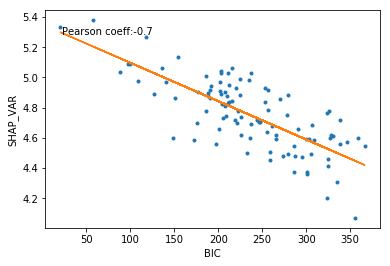

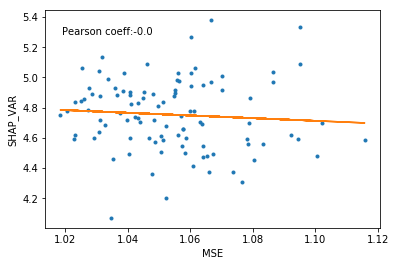

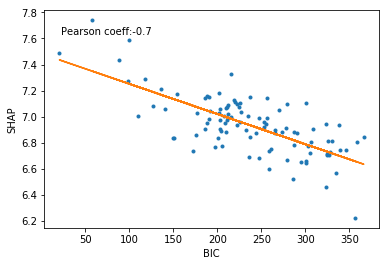

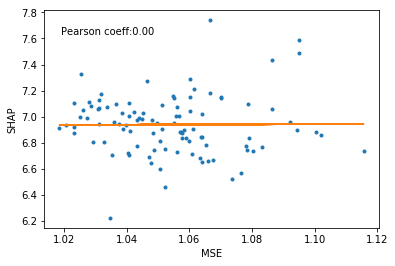

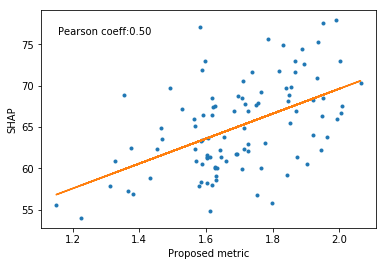

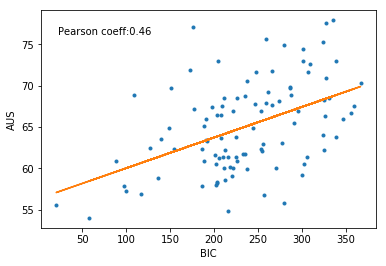

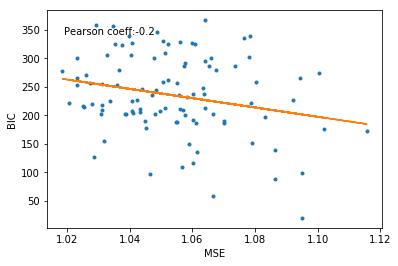

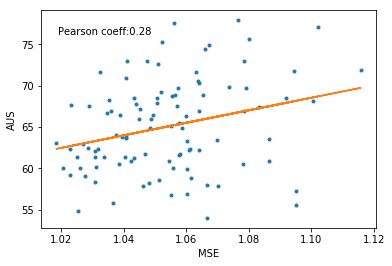

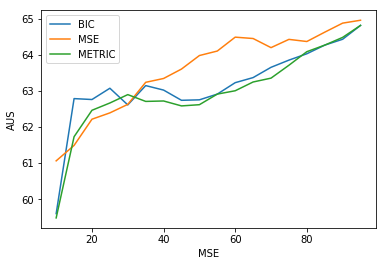

0.5075729880065726

In [7]:
from numpy.polynomial.polynomial import polyfit  
from scipy.stats import pearsonr
from pylab import text

fig, ax = plt.subplots()
b,m = polyfit(VIO,SHAP_VAR, 1)
#ax.plot(VIO,AUS, '.')

ax.plot(VIO,SHAP_VAR, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(VIO,SHAP_VAR)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(VIO, b + m * np.array(VIO), '-')
ax.set_xlabel("BIC")
ax.set_ylabel("SHAP_VAR")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,SHAP_VAR, 1)
#ax.plot(VIO,AUS, '.')

ax.plot(MSE,SHAP_VAR, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,SHAP_VAR)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(MSE, b + m * np.array(MSE), '-')
ax.set_xlabel("MSE")
ax.set_ylabel("SHAP_VAR")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
b,m = polyfit(VIO,SHAP, 1)
#ax.plot(VIO,AUS, '.')

ax.plot(VIO,SHAP, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(VIO,SHAP)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(VIO, b + m * np.array(VIO), '-')
ax.set_xlabel("BIC")
ax.set_ylabel("SHAP")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()



fig, ax = plt.subplots()
b,m = polyfit(MSE,SHAP, 1)
ax.plot(MSE,SHAP, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,SHAP)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(MSE, b + m * np.array(MSE), '-')
ax.set_xlabel("MSE")
ax.set_ylabel("SHAP")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()


METRIC = (VIO/np.max(VIO)) + np.array(MSE)
fig, ax = plt.subplots()
b,m = polyfit(METRIC,AUS, 1)
ax.plot(METRIC,AUS, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(METRIC,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(METRIC, b + m * np.array(METRIC), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Proposed metric")
ax.set_ylabel("SHAP")
fig.savefig('Ex4ProposedVsAUS.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
b,m = polyfit(VIO,AUS, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(VIO,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(VIO,AUS, '.')
plt.plot(VIO, b + m * np.array(VIO), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("BIC")
ax.set_ylabel("AUS")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,VIO, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,VIO)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(MSE,VIO, '.')
plt.plot(MSE, b + m * np.array(MSE), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("MSE")
ax.set_ylabel("BIC")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,AUS, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(MSE,AUS, '.')
plt.plot(MSE, b + m * np.array(MSE), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


MSE = np.array(MSE)

x = []
y1 = []
y2 = []
y3 = []
for split in range(10, len(AUS), 5):
    #print("******", split, "*******")
    sorted_aus = [AUS for _,AUS in sorted(zip(VIO,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(VIO,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]

    x.append(split)
    
    
    #print("Low Violations = ", np.mean(low), "for", len(low))
    #print("High Violations = ", np.mean(high), "for", len(high))
    y1.append(np.mean(low))
    sorted_aus_by_mse = [AUS for _,AUS in sorted(zip(MSE,AUS))]
    low = sorted_aus_by_mse[:split]
    high = sorted_aus_by_mse[split:]
    #print("Low AUS by MSE = ", np.mean(low), "for", len(low))
    #print("High AUS by MSE = ", np.mean(high), "for", len(high))
    y2.append(np.mean(low))
    sorted_aus = [AUS for _,AUS in sorted(zip(METRIC,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(METRIC,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]



    #print("Low Metric = ", np.mean(low), "for", len(low))
    #print("High Metric = ", np.mean(high), "for", len(high))
    y3.append(np.mean(low))
    

fig, ax = plt.subplots()

ax.plot(x,y1, '-', label = 'BIC')
ax.plot(x,y2, '-', label = 'MSE')
ax.plot(x,y3, '-', label = 'METRIC')
ax.legend()

ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
plt.show()  
pearsonr(METRIC,AUS)[0]

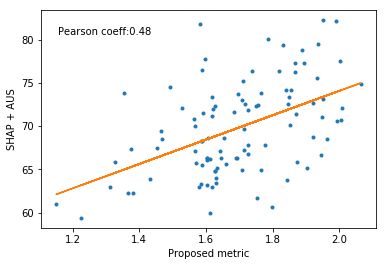

In [8]:
fig, ax = plt.subplots()

b,m = polyfit(METRIC,np.array(AUS) + np.array(SHAP_VAR), 1)
ax.plot(METRIC,np.array(AUS) + np.array(SHAP_VAR), '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(METRIC,np.array(AUS) + np.array(SHAP_VAR))[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(METRIC, b + m * np.array(METRIC), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Proposed metric")
ax.set_ylabel("SHAP + AUS")
fig.savefig('Ex4ProposedVsAUS.pdf', bbox_inches='tight')
plt.show()

In [9]:
def norm(a):
    return (a - np.min(a)) / a.ptp()
METRIC = norm(np.array(VIO)) + norm(np.array(MSE))
n_low = 20

sorted_aus = [SHAP_VAR for _,SHAP_VAR in sorted(zip(VIO,SHAP_VAR))]
print("SHAP VAR Best by BIC = ", np.mean(sorted_aus[:n_low]))

sorted_aus = [SHAP_VAR for _,SHAP_VAR in sorted(zip(MSE,SHAP_VAR))]
print("SHAP VAR Best by MSE = ", np.mean(sorted_aus[:n_low]))


sorted_aus = [SHAP_VAR for _,SHAP_VAR in sorted(zip(METRIC,SHAP_VAR))]
print("SHAP VAR Best by MET = ", np.mean(sorted_aus[:n_low]))
print("SHAP VAR Random = ", np.mean(SHAP_VAR[:n_low]))

sorted_aus = [SHAP for _,SHAP in sorted(zip(VIO,SHAP))]
print("SHAP Best by BIC = ", np.mean(sorted_aus[:n_low]))

sorted_aus = [SHAP for _,SHAP in sorted(zip(MSE,SHAP))]
print("SHAP Best by MSE = ", np.mean(sorted_aus[:n_low]))


sorted_aus = [SHAP for _,SHAP in sorted(zip(METRIC,SHAP))]
print("SHAP Best by MET = ", np.mean(sorted_aus[:n_low]))
print("SHAP Random = ", np.mean(SHAP[:n_low]))

sorted_aus = [AUS for _,AUS in sorted(zip(VIO,AUS))]
print("AUS Best by BIC = ", np.mean(sorted_aus[:n_low]))

sorted_aus = [AUS for _,AUS in sorted(zip(MSE,AUS))]
print("AUS Best by MSE = ", np.mean(sorted_aus[:n_low]))


sorted_aus = [AUS for _,AUS in sorted(zip(METRIC,AUS))]
print("AUS Best by MET = ", np.mean(sorted_aus[:n_low]))
print("AUS Random = ", np.mean(AUS[:n_low]))

SHAP VAR Best by BIC =  4.972411051362455
SHAP VAR Best by MSE =  4.784592984927893
SHAP VAR Best by MET =  4.951774214769227
SHAP VAR Random =  4.734238287335183
SHAP Best by BIC =  7.140023839333982
SHAP Best by MSE =  6.979289730951692
SHAP Best by MET =  7.096790528863034
SHAP Random =  6.919361879875476
AUS Best by BIC =  62.76545730219276
AUS Best by MSE =  62.21920521219173
AUS Best by MET =  61.305604607612146
AUS Random =  65.68535372012198


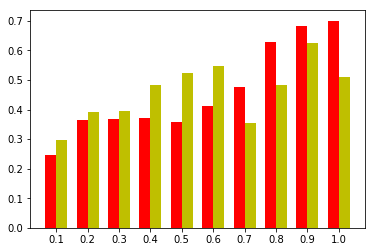

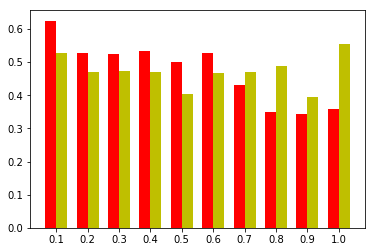

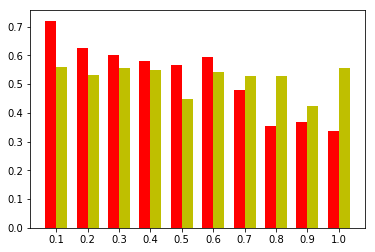

In [10]:
def plot_comparison(x1, x2, y,  bins = 10):
    sorted_y_by_x1 = [y for _,y in sorted(zip(x1,y))]
    sorted_y_by_x2 = [y for _,y in sorted(zip(x2,y))]
    total_len = len(sorted_y_by_x1)
    X = []
    Y1 = []
    Y2 = []
    for i in range(1, bins + 1):
        X.append(i / bins)
        Y1.append(np.mean(sorted_y_by_x1[int((i - 1)*(total_len/bins)):int(i*(total_len/bins))]))
        Y2.append(np.mean(sorted_y_by_x2[int((i - 1)*(total_len/bins)):int(i*(total_len/bins))]))
       
    fig, ax = plt.subplots()

    ind = np.arange(bins)    # the x locations for the groups
    width = 0.35         # the width of the bars
    p1 = ax.bar(ind, Y1, width, color='r',)

    p2 = ax.bar(ind + width, Y2, width,
                color='y' )

    #ax.set_title('Scores by group and gender')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(X)

    #ax.legend((p1[0], p2[0]), ('Men', 'Women'))
    #ax.yaxis.set_units(inch)
    ax.autoscale_view()

    plt.show()

def normalize(a):
    return (a - np.min(a)) / (np.max(a) - np.min(a))
plot_comparison(METRIC, MSE, normalize(AUS))
plot_comparison(METRIC, MSE, normalize(SHAP))
plot_comparison(METRIC, MSE, normalize(SHAP_VAR))
#plot_comparison(MSE, normalize(AUS))

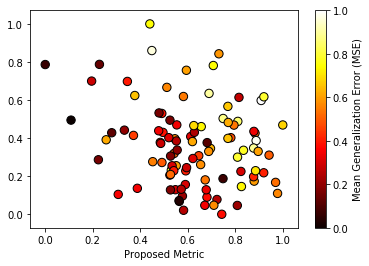

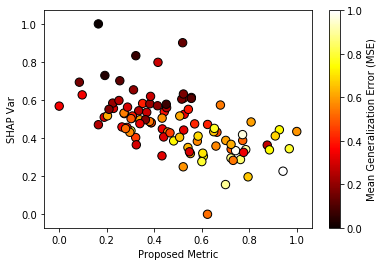

In [11]:
def heat_plot(x,y,z, xlab = 'Mean', ylab = 'Variance', zlab= 'Mean Generalization Error (MSE)', clim_low = 0, clim_high = 1):
    fig, ax = plt.subplots()

    cax = ax.scatter(x, y, c=z, s=70, edgecolor='black', cmap = 'hot')
    cax.set_clim(clim_low, clim_high)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    #plt.colorbar(cax)
    cbar = plt.colorbar(cax)
    cbar.set_label(zlab)
    plt.show()
    
heat_plot(normalize(VIO), normalize(MSE), normalize(AUS), xlab = 'Proposed Metric', ylab = '', )

heat_plot(normalize(METRIC), normalize(SHAP), normalize(AUS), xlab = 'Proposed Metric', ylab = 'SHAP Var', )